In [2]:
import xarray as xr
import pandas as pd
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [3]:
import numpy as np

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [4]:
import torch 

land_mask = ~np.isnan(temp)
land_mask_torch = torch.from_numpy(land_mask.astype(bool)) 

print(temp.shape)
print(land_mask.shape)

(648, 112, 82)
(648, 112, 82)


In [5]:
from skimage import measure

# Connected components labeling
labels = measure.label(land_mask)
biggest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1  

# Isolate the biggest component
main_landmass_mask = (labels == biggest_component_label) 

# Get indices for bounding box
nonzero_indices = main_landmass_mask.nonzero()
min_row = np.min(nonzero_indices[1])
max_row = np.max(nonzero_indices[1])
min_col = np.min(nonzero_indices[2])
max_col = np.max(nonzero_indices[2])

In [6]:
print(min_row)
print(max_row)
print(min_col)
print(max_col)

10
89
28
72


In [7]:
rain = rain[:, min_row:max_row + 1, min_col:max_col + 1]
hurs = hurs[:, min_row:max_row + 1, min_col:max_col + 1]
temp = temp[:, min_row:max_row + 1, min_col:max_col + 1]
temp_max = temp_max[:, min_row:max_row + 1, min_col:max_col + 1]
temp_min = temp_min[:, min_row:max_row + 1, min_col:max_col + 1]
sun = sun[:, min_row:max_row + 1, min_col:max_col + 1] 
frost = frost[:, min_row:max_row + 1, min_col:max_col + 1] 
psl = psl[:, min_row:max_row + 1, min_col:max_col + 1] 
wind = wind[:, min_row:max_row + 1, min_col:max_col + 1] 
land_mask = land_mask[:, min_row:max_row + 1, min_col:max_col + 1]

In [8]:
rain.shape

(648, 80, 45)

In [9]:
nan_indices = np.where(np.isnan(rain))
print(nan_indices)  # Prints arrays of indices (time, row, col) where NaNs exist

(array([  0,   0,   0, ..., 647, 647, 647], dtype=int64), array([ 0,  0,  0, ..., 79, 79, 79], dtype=int64), array([ 0,  1,  2, ..., 42, 43, 44], dtype=int64))


In [10]:
nan_counts = np.count_nonzero(np.isnan(rain), axis=0)  # Counts across time

valid_grid_cell_mask = nan_counts == 0
valid_cell_indices = np.where(valid_grid_cell_mask)

In [11]:
valid_cell_indices

(array([ 0,  1,  1, ..., 79, 79, 79], dtype=int64),
 array([ 4,  2,  3, ..., 15, 16, 17], dtype=int64))

In [12]:
# Your arrays from the previous output:
row_indices = valid_cell_indices[0]
col_indices = valid_cell_indices[1]

unique_rows, row_counts = np.unique(row_indices, return_counts=True)
unique_cols, col_counts = np.unique(col_indices, return_counts=True)

print("Unique row indices:", unique_rows)
print("Number of unique row indices:", len(unique_rows))
print("Counts of each unique row index:", row_counts)

print("\nUnique column indices:", unique_cols)
print("Number of unique column indices:", len(unique_cols))
print("Counts of each unique column index:", col_counts)

Unique row indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
Number of unique row indices: 80
Counts of each unique row index: [ 1  3  4  8 10 10 16 22 31 33 32 27 25 24 25 31 35 37 37 35 35 33 33 33
 33 32 33 30 26 26 25 21 18 17 17 16 15 15 17 19 22 20 18 15 17 23 21 21
 20 17 18 18 18 17 19 15 13 15 14 16 17 19 19 18 18 20 18 21 21 23 20 10
 10  8  8 11 12 12 12  7]

Unique column indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Number of unique column indices: 45
Counts of each unique column index: [17 21 18 13 18 26 29 32 41 54 53 56 60 57 55 57 59 57 61 62 60 57 55 51
 45 44 39 36 35 34 35 33 31 28 27 23 19 19 20 17 15 14 10  7  1]


In [13]:
nan_indices = np.where(np.isnan(temp))
print(nan_indices)

(array([  0,   0,   0, ..., 647, 647, 647], dtype=int64), array([ 0,  0,  0, ..., 79, 79, 79], dtype=int64), array([ 0,  1,  2, ..., 42, 43, 44], dtype=int64))


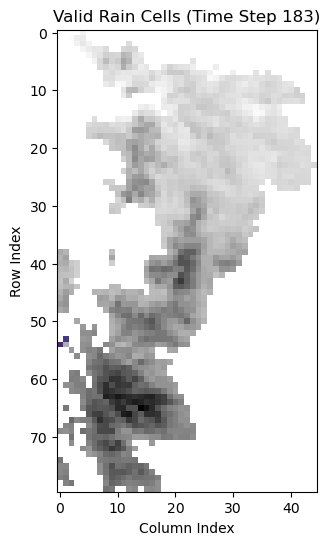

In [14]:
import matplotlib.pyplot as plt

valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

time_step = 183

original_rain_slice = rain[time_step, :, :]  
original_temp_slice = temp[time_step, :, :]

# Visualization
plt.figure(figsize=(10, 6)) 
plt.imshow(original_rain_slice, cmap='viridis')  # Faint background
plt.imshow(original_temp_slice, cmap='gray')  
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Valid Rain Cells (Time Step {})'.format(time_step))
plt.show()

In [15]:
valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

valid_rain_data = rain[:, valid_row_indices, valid_col_indices]

In [16]:
valid_rain_data.shape

(648, 1601)

In [17]:
has_nan = np.isnan(valid_rain_data).any()
print(has_nan)

False


In [18]:
valid_temp_data = temp[:, valid_row_indices, valid_col_indices]
valid_wind_data = wind[:, valid_row_indices, valid_col_indices]
valid_hurs_data = hurs[:, valid_row_indices, valid_col_indices]
valid_psl_data = psl[:, valid_row_indices, valid_col_indices]
valid_frost_data = frost[:, valid_row_indices, valid_col_indices]
valid_sun_data = sun[:, valid_row_indices, valid_col_indices]
valid_tmax_data = temp_max[:, valid_row_indices, valid_col_indices]
valid_tmin_data = temp_min[:, valid_row_indices, valid_col_indices]

In [19]:
has_nan = np.isnan(valid_temp_data).any()
print(has_nan)

True


In [20]:
valid_frost_data.shape

(648, 1601)

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# List of variables to normalize
variables = [
    valid_rain_data, valid_temp_data, valid_wind_data, 
    valid_hurs_data, valid_psl_data, valid_sun_data,
    valid_frost_data, valid_tmax_data, valid_tmin_data
] 

# Normalize each variable in-place
for data in variables:
    # Fit on assumed training data (replace with your actual training set)
    scaler.fit(data)  

    # Transform and overwrite the existing variable
    data[:] = scaler.transform(data) 

In [22]:
valid_rain_data = valid_rain_data[:,:1600].reshape(648, 64, 25)
valid_temp_data = valid_temp_data[:,:1600].reshape(648, 64, 25)
valid_wind_data = valid_wind_data[:,:1600].reshape(648, 64, 25)
valid_hurs_data = valid_hurs_data[:,:1600].reshape(648, 64, 25)
valid_psl_data = valid_psl_data[:,:1600].reshape(648, 64, 25)
valid_sun_data = valid_sun_data[:,:1600].reshape(648, 64, 25)
valid_frost_data = valid_frost_data[:,:1600].reshape(648, 64, 25)
valid_tmax_data = valid_tmax_data[:,:1600].reshape(648, 64, 25)
valid_tmin_data = valid_tmin_data[:,:1600].reshape(648, 64, 25)

In [23]:
data_list = [valid_rain_data, valid_temp_data, valid_wind_data, valid_hurs_data, valid_psl_data, valid_sun_data, valid_frost_data, valid_tmax_data, valid_tmin_data]

for data in data_list:
    print(np.isnan(data).any())

False
True
True
False
False
False
False
True
True


In [24]:
nan_indices = np.where(np.isnan(valid_temp_data))
print(nan_indices)

(array([183, 183, 184, 184, 185, 185, 186, 186, 187, 187, 188, 188, 189,
       189, 190, 190, 191, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 432, 432, 432, 432, 432, 433, 433, 433, 433,
       433, 434, 434, 434, 434, 434], dtype=int64), array([47, 48, 47, 48, 47, 48, 47, 48, 47, 48, 47, 48, 47, 48, 47, 48, 47,
       48, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,

In [25]:
print(valid_temp_data[:,47,13])

[0.35938575 0.27749489 0.36212467 0.44757497 0.57202964 0.74117188
 0.90298382 0.90063293 0.81695007 0.59898125 0.36254269 0.30144754
 0.22755749 0.2570674  0.27963128 0.40873434 0.47362899 0.68468858
 0.84588614 0.80675489 0.6893773  0.45438275 0.36361327 0.32771914
 0.15593678 0.16370686 0.23178141 0.39756352 0.499075   0.69623834
 0.88868144 0.8249822  0.74559394 0.66108209 0.45776399 0.20273839
 0.25835225 0.29850122 0.35282292 0.39826746 0.63132454 0.86720579
 0.90584875 0.82307573 0.72313311 0.48399981 0.31725686 0.26178411
 0.31434027 0.1744296  0.18857909 0.38073648 0.57973526 0.73297512
 0.77140013 0.79902672 0.72866841 0.59263218 0.43246725 0.37919875
 0.31976188 0.22985651 0.33649403 0.3937734  0.71198284 0.82995591
 0.8608927  0.82158623 0.7747242  0.55896385 0.48723828 0.37898101
 0.38718575 0.21271894 0.37605224 0.45076761 0.68901388 0.73363458
 0.8133263  0.84297304 0.86232021 0.64231169 0.39782603 0.20427126
 0.26646895 0.37130047 0.25017221 0.35215766 0.55016429 0.8420

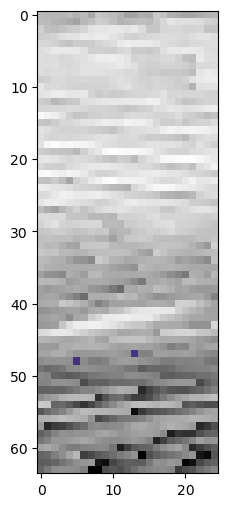

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.imshow(valid_rain_data[183,:,:], cmap='viridis')  # Sample timestep
plt.imshow(valid_temp_data[183,:,:], cmap='gray')
plt.show()

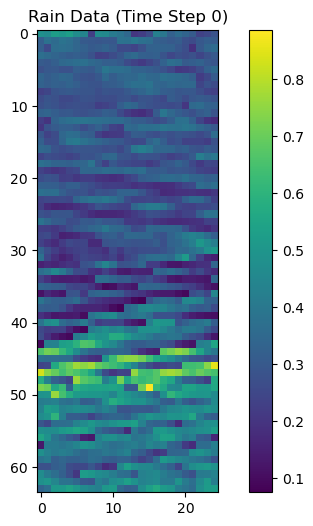

In [27]:
import matplotlib.pyplot as plt

def visualize_reshaped_slice(data, time_index, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(data[time_index]) 
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example using valid_rain_data
time_step = 0  # Choose a time step
visualize_reshaped_slice(valid_rain_data, time_step, 'Rain Data (Time Step {})'.format(time_step))


In [29]:
nan_count_temp = np.isnan(valid_temp_data).sum()
nan_count_tmax = np.isnan(valid_tmax_data).sum()
nan_count_tmin = np.isnan(valid_tmin_data).sum()
nan_count_wind = np.isnan(valid_wind_data).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Wind:', nan_count_wind)

Number of NaN values in Temp: 123
Number of NaN values in Tmax: 108
Number of NaN values in Tmin: 123
Number of NaN values in Wind: 167


In [30]:
def fill_nan_with_mean(data):
    col_mean = np.nanmean(data, axis=0)  # Calculate mean per column
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])  # Replace NaNs with mean
    return data

temp_filled = fill_nan_with_mean(valid_temp_data.copy())  
tmax_filled = fill_nan_with_mean(valid_tmax_data.copy())
tmin_filled = fill_nan_with_mean(valid_tmin_data.copy())
wind_filled = fill_nan_with_mean(valid_wind_data.copy())

In [31]:
nan_count_temp = np.isnan(temp_filled).sum()
nan_count_tmax = np.isnan(tmax_filled).sum()
nan_count_tmin = np.isnan(tmin_filled).sum()
nan_count_wind = np.isnan(wind_filled).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Tmin:', nan_count_tmin)

Number of NaN values in Temp: 0
Number of NaN values in Tmax: 0
Number of NaN values in Tmin: 0
Number of NaN values in Tmin: 0


In [32]:
print(temp_filled.shape)
print(tmax_filled.shape)
print(tmin_filled.shape)
print(wind_filled.shape)

(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)


In [33]:
def prepare_for_convlstm(data, seq_length, num_channels):  
    batch_size = 32  
    data = data.reshape(batch_size, seq_length, num_channels, h, w)
    return data 

In [34]:
rain_tensor = torch.from_numpy(valid_rain_data)
temp_tensor = torch.from_numpy(temp_filled)
hurs_tensor = torch.from_numpy(valid_hurs_data)
frost_tensor = torch.from_numpy(valid_frost_data)
sun_tensor = torch.from_numpy(valid_sun_data)
wind_tensor = torch.from_numpy(wind_filled)
psl_tensor = torch.from_numpy(valid_psl_data)
tmax_tensor = torch.from_numpy(tmax_filled)
tmin_tensor = torch.from_numpy(tmin_filled)

In [35]:
variables = [rain_tensor, temp_tensor, hurs_tensor, frost_tensor, sun_tensor, wind_tensor, psl_tensor, tmax_tensor, tmin_tensor] 

# Stack along the channels dimension (dim=1)
stacked_tensor = torch.stack(variables, dim=1)  

In [36]:
stacked_array = stacked_tensor.numpy() 

print(stacked_array.shape)

(648, 9, 64, 25)


In [37]:
def create_labels(num_data_points):
    """
    Creates labels for the climate data, assigning 0 for pre-1990 and 1 for post-1990. 
    Data is in chronological order from January 1969.

    Args:
        num_data_points: The total number of data points (months) in dataset

    Returns:
        A NumPy array of labels.
    """

    years = np.linspace(1969, 2023, 648)  
    labels = np.where(years < 1989, 0, 1) 

    
    return labels[:num_data_points] 

num_samples = stacked_array.shape[0]
labels = create_labels(num_samples) 

In [38]:
from convlstm import ConvLSTM

In [39]:
import torch  

num_layers = 2  
hidden_dim = 64 
kernel_size = (5, 5)  
input_channels = 9   

model = ConvLSTM(input_dim=input_channels,
                    hidden_dim=hidden_dim,
                    kernel_size=kernel_size,
                    num_layers=num_layers,
                    batch_first=True,  
                    return_all_layers=False)

In [40]:
from sklearn.model_selection import train_test_split

num_samples = stacked_array.shape[0]
reshaped_data = stacked_array.reshape(num_samples, -1)
labels = create_labels(num_samples) 

print('Reshaped Data', reshaped_data.shape)  
print('Labels', labels.shape)

# Get indices for training and remaining data
train_idx, remaining_idx = train_test_split(np.arange(num_samples), test_size=0.3, random_state=42, shuffle=True) 

# Subset data using calculated indices  
X_train = reshaped_data[train_idx]
y_train = labels[train_idx]

# Get indices for validation and test within the "remaining" data
val_idx, test_idx = train_test_split(remaining_idx, test_size=0.5, random_state=42, shuffle=True) 

# Subset the remaining data accordingly
X_val = reshaped_data[val_idx]
y_val = labels[val_idx]

X_test = reshaped_data[test_idx]
y_test = labels[test_idx]

X_train = torch.tensor(X_train, dtype=torch.float32)  
X_val = torch.tensor(X_val, dtype=torch.float32)  
X_test = torch.tensor(X_test, dtype=torch.float32)  

y_train = torch.tensor(y_train, dtype=torch.long)  
y_val = torch.tensor(y_val, dtype=torch.long)  
y_test = torch.tensor(y_test, dtype=torch.long) 

Reshaped Data (648, 14400)
Labels (648,)


In [43]:
len(X_train)

453

In [41]:
import torch 
from torch.utils.data import Dataset, DataLoader

class ClimateDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.clone().detach()  # Change here
        self.y = y.clone().detach() 

    def __len__(self):
        return len(self.X)  

    def __getitem__(self, index):
        x = self.X[index]
        x = x.unsqueeze(0)  
        
        label = self.y[index]
        one_hot_label = torch.zeros(2)  # Create a 2D vector 
        one_hot_label[label] = 1.0        
        y = one_hot_label
        return x, y  
        

In [44]:
def reshape_for_convlstm(X, seq_length): 
    channels = 9
    height = 64
    width = 25
    return X.reshape(seq_length, channels, height, width) 

X_train = reshape_for_convlstm(X_train, seq_length=len(X_train))
X_val = reshape_for_convlstm(X_val, seq_length=len(X_val))
X_test = reshape_for_convlstm(X_test, seq_length=len(X_test))

In [45]:
print('Shape of training', X_train.shape)
print('Shape of validation', X_val.shape)
print('Shape of testing', X_test.shape)

Shape of training torch.Size([453, 9, 64, 25])
Shape of validation torch.Size([97, 9, 64, 25])
Shape of testing torch.Size([98, 9, 64, 25])


In [46]:
train_dataset = ClimateDataset(X_train, y_train)
val_dataset = ClimateDataset(X_val, y_val)
test_dataset = ClimateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)  
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

print("Train Dataset Length:",  len(dataloaders['train'].dataset)) 
print("Validation Dataset Length:",  len(dataloaders['val'].dataset)) 

Train Dataset Length: 453
Validation Dataset Length: 97


In [51]:
import torch.nn as nn
device = torch.device("cpu") # Weight for the positive class (ratio of negative to positive examples)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
num_epochs = 100

In [52]:
import time 

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []  
    train_accuracies, val_accuracies = [], []  

    for epoch in range(num_epochs):
        start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # Assuming you have a 'device' 
                labels = labels.to(device)

                optimizer.zero_grad() # Zero the gradients

                # Only calculate and update gradients during training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) 
                    loss = criterion(outputs, labels) 

                    _, preds = torch.max(outputs, 1)  

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate statistics 
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, dim=1) 
                _, labels_indices = torch.max(labels, dim=1)  # Convert labels back 
                running_corrects += torch.sum(preds == labels_indices)

            # Calculate and record metrics per epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            end_time = time.time()
            time_elapsed = end_time - start_time

            print(f'Epoch {epoch+1}/{num_epochs}, {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Time: {time_elapsed:.2f}s') 

    return model, train_losses, val_losses, train_accuracies, val_accuracies 

In [53]:
import matplotlib.pyplot as plt

def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(10,5))

    # Losses
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracies
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 1/100, train Loss: 0.6936, Acc: 0.4923, Time: 18.25s
Epoch 1/100, val Loss: 0.6935, Acc: 0.4742, Time: 19.80s
Epoch 2/100, train Loss: 0.6939, Acc: 0.4415, Time: 19.24s
Epoch 2/100, val Loss: 0.6942, Acc: 0.4124, Time: 20.88s
Epoch 3/100, train Loss: 0.6936, Acc: 0.4724, Time: 19.47s
Epoch 3/100, val Loss: 0.6928, Acc: 0.4948, Time: 21.13s
Epoch 4/100, train Loss: 0.6926, Acc: 0.5740, Time: 20.00s
Epoch 4/100, val Loss: 0.6939, Acc: 0.4536, Time: 21.70s
Epoch 5/100, train Loss: 0.6925, Acc: 0.5232, Time: 20.34s
Epoch 5/100, val Loss: 0.6959, Acc: 0.4227, Time: 22.07s
Epoch 6/100, train Loss: 0.6940, Acc: 0.5254, Time: 20.34s
Epoch 6/100, val Loss: 0.6943, Acc: 0.5155, Time: 22.01s
Epoch 7/100, train Loss: 0.6919, Acc: 0.5210, Time: 20.45s
Epoch 7/100, val Loss: 0.6910, Acc: 0.5052, Time: 22.17s
Epoch 8/100, train Loss: 0.6916, Acc: 0.5276, Time: 20.10s
Epoch 8/100, val Loss: 0.6935, Acc: 0.5670, Time: 21.77s
Epoch 9/100, train Loss: 0.6948, Acc: 0.4834, Time: 20.48s
Epoch 9/100, 

Epoch 71/100, train Loss: 0.6927, Acc: 0.5121, Time: 21.73s
Epoch 71/100, val Loss: 0.6947, Acc: 0.4536, Time: 23.56s
Epoch 72/100, train Loss: 0.6942, Acc: 0.5320, Time: 21.36s
Epoch 72/100, val Loss: 0.6923, Acc: 0.5979, Time: 23.14s
Epoch 73/100, train Loss: 0.6949, Acc: 0.5011, Time: 21.54s
Epoch 73/100, val Loss: 0.6922, Acc: 0.5773, Time: 23.42s
Epoch 74/100, train Loss: 0.6926, Acc: 0.5563, Time: 21.85s
Epoch 74/100, val Loss: 0.6910, Acc: 0.6186, Time: 23.67s
Epoch 75/100, train Loss: 0.6932, Acc: 0.5232, Time: 21.70s
Epoch 75/100, val Loss: 0.6944, Acc: 0.4021, Time: 23.59s
Epoch 76/100, train Loss: 0.6931, Acc: 0.4680, Time: 22.04s
Epoch 76/100, val Loss: 0.6935, Acc: 0.4330, Time: 23.87s
Epoch 77/100, train Loss: 0.6906, Acc: 0.5629, Time: 21.95s
Epoch 77/100, val Loss: 0.6906, Acc: 0.5464, Time: 23.79s
Epoch 78/100, train Loss: 0.6974, Acc: 0.4481, Time: 22.05s
Epoch 78/100, val Loss: 0.7032, Acc: 0.3814, Time: 23.93s
Epoch 79/100, train Loss: 0.6963, Acc: 0.4945, Time: 22.

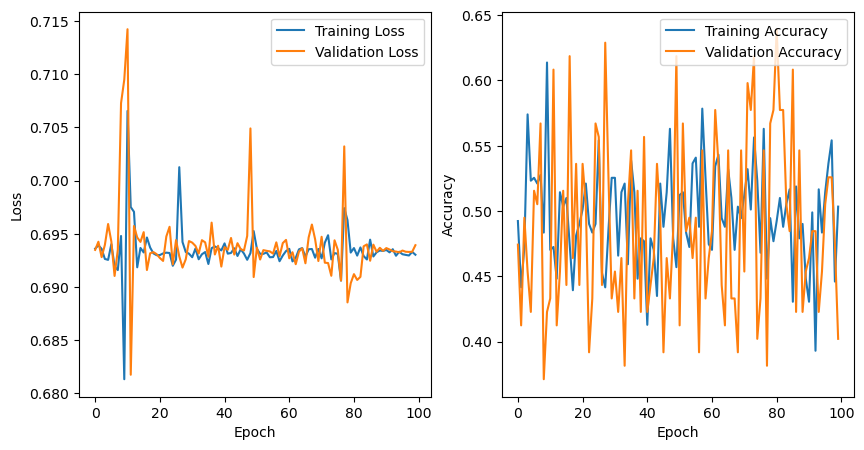

In [54]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, dataloaders, criterion, optimizer, num_epochs)

# Print final accuracies
print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}') 

plot_results(train_losses, val_losses, train_accuracies, val_accuracies) 